In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from os import path, makedirs
import json
from scipy.stats import wilcoxon, shapiro, normaltest, ttest_rel
import numpy as np

In [2]:
systems_type = CategoricalDtype(
    categories=["UAM-CSI", "Viking-7B", "Viking-13B"], ordered=True
)
styles_type = CategoricalDtype(
    categories=["minimal", "fluency"], ordered=True
)

In [3]:
scores_csv_file = "scores.csv"
auto_df = pd.read_csv(scores_csv_file)


auto_df_long = auto_df.melt(
    id_vars=["essay_id", "correction_style", "system"],
    value_vars=["gleu", "precision", "recall", "f0.5", "scribendi_score"],
    var_name="metric",
    value_name="score",
)

print(auto_df_long.info())

styles = auto_df_long["correction_style"].unique().tolist()
teams = auto_df_long["system"].unique().tolist()

output_metrics = {
    "grammaticality": "SOME: Grammaticality",
    "fluency": "SOME: Fluency",
    "meaning_preservation": "SOME: Meaning Preservation",
    "manual_evaluation": "SOME: Total",
    "gleu": "GLEU",
    "precision": "ERRANT: Precision",
    "recall": "ERRANT: Recall",
    "f0.5": "ERRANT: $ \\text{F}_{0.5} $-Score",
    "scribendi_score": "Scribendi Score",
}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   essay_id          1500 non-null   object 
 1   correction_style  1500 non-null   object 
 2   system            1500 non-null   object 
 3   metric            1500 non-null   object 
 4   score             1500 non-null   float64
dtypes: float64(1), object(4)
memory usage: 58.7+ KB
None


In [4]:
manual_evaluation_dir = "manual_evaluation/"
d_key = "evaluations"

manual_eval_dicts = []

for team in teams:
    team_dir = path.join(manual_evaluation_dir, team)
    for style in styles:
        style_file_name = f"{style}.json"
        style_file_path = path.join(team_dir, style_file_name)
        with open(style_file_path) as f:
            metric_df = json.load(f)
        scores = metric_df[d_key]
        for d in scores:
            total = 0
            for metric in ["grammaticality", "fluency", "meaning_preservation"]:
                manual_eval_dicts.append(
                    {
                        "essay_id": d["id"],
                        "correction_style": style,
                        "system": team,
                        "metric": metric,
                        "score": d[metric],
                    }
                )
                total += d[metric]
            manual_eval_dicts.append(
                {
                    "essay_id": d["id"],
                    "correction_style": style,
                    "system": team,
                    "metric": "manual_evaluation",
                    "score": total / 3,
                }
            )

manual_df_long = pd.DataFrame(manual_eval_dicts)

In [5]:
dfs = [auto_df_long, manual_df_long]
df_long = pd.concat(dfs)
df_long["system"] = df_long["system"].astype(systems_type)
df_long["correction_style"] = df_long["correction_style"].astype(styles_type)
print(df_long.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2700 entries, 0 to 1199
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   essay_id          2700 non-null   object  
 1   correction_style  2700 non-null   category
 2   system            2700 non-null   category
 3   metric            2700 non-null   object  
 4   score             2700 non-null   float64 
dtypes: category(2), float64(1), object(2)
memory usage: 89.9+ KB
None


In [6]:
essay_ids = df_long["essay_id"].unique().tolist()


essay_id_subs = {essay_id: i for i, essay_id in enumerate(essay_ids, 1)}

df_long["essay_id"] = df_long["essay_id"].map(essay_id_subs)
print(df_long.info())

metrics = df_long["metric"].unique().tolist()
print(metrics)

<class 'pandas.core.frame.DataFrame'>
Index: 2700 entries, 0 to 1199
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   essay_id          2700 non-null   int64   
 1   correction_style  2700 non-null   category
 2   system            2700 non-null   category
 3   metric            2700 non-null   object  
 4   score             2700 non-null   float64 
dtypes: category(2), float64(1), int64(1), object(1)
memory usage: 89.9+ KB
None
['gleu', 'precision', 'recall', 'f0.5', 'scribendi_score', 'grammaticality', 'fluency', 'meaning_preservation', 'manual_evaluation']


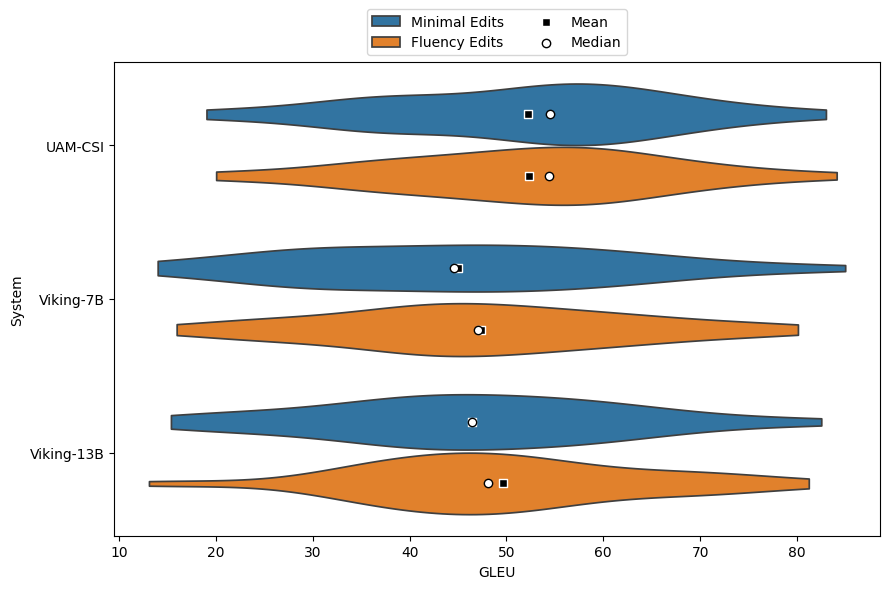

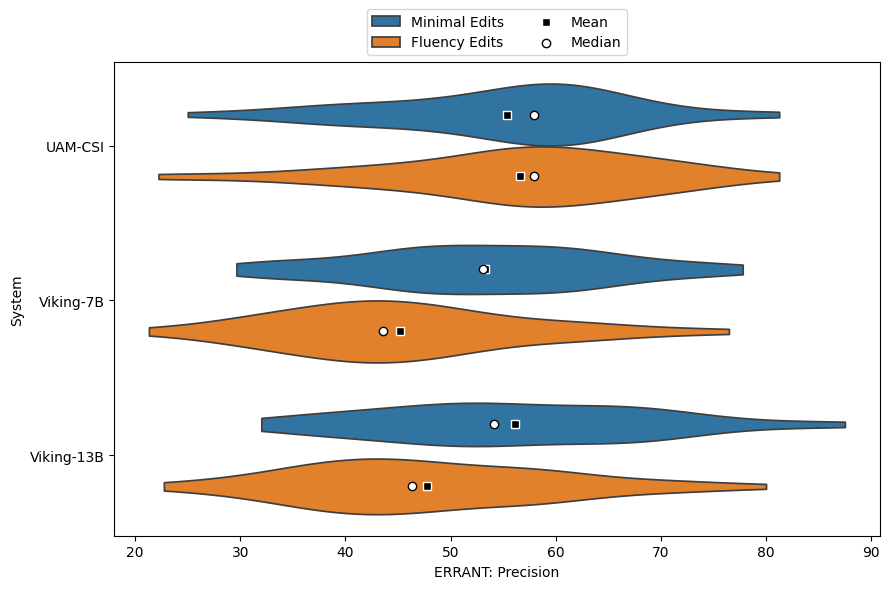

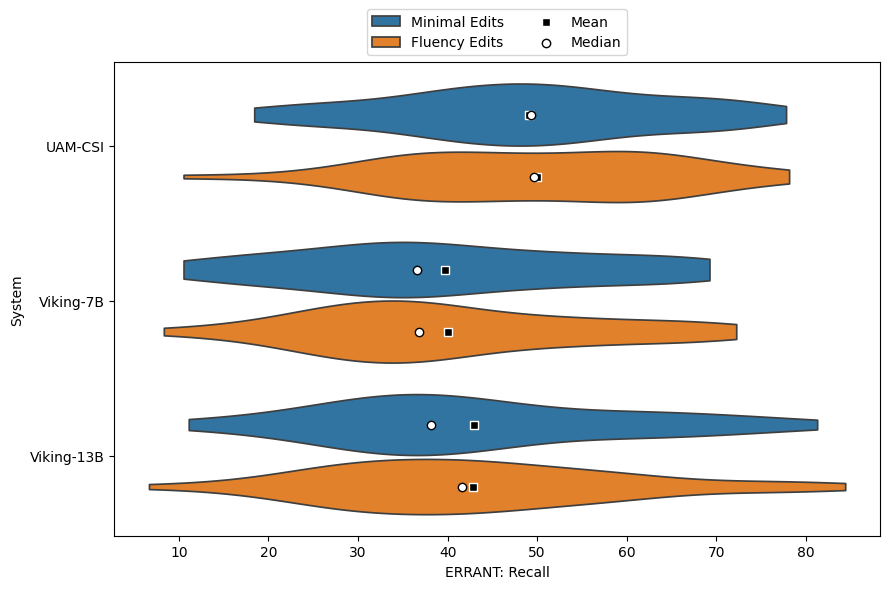

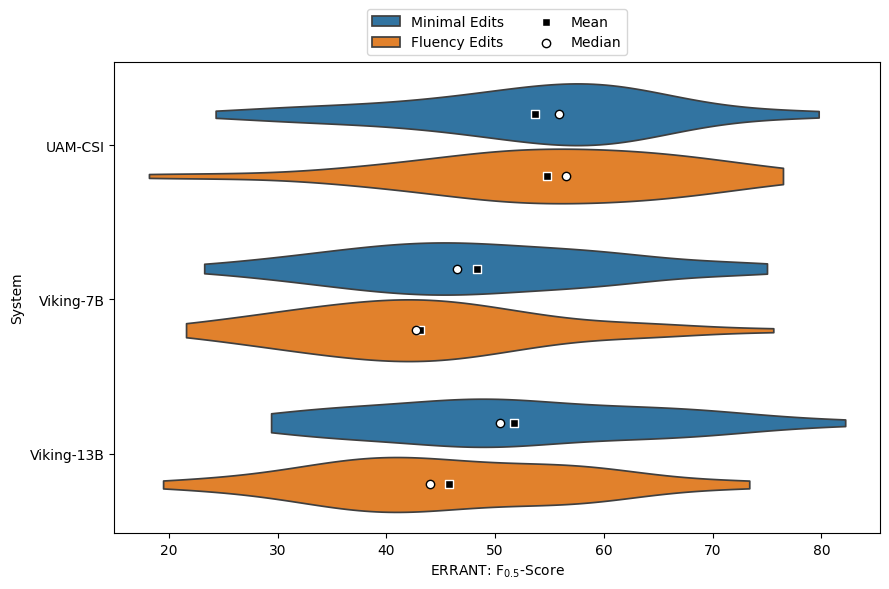

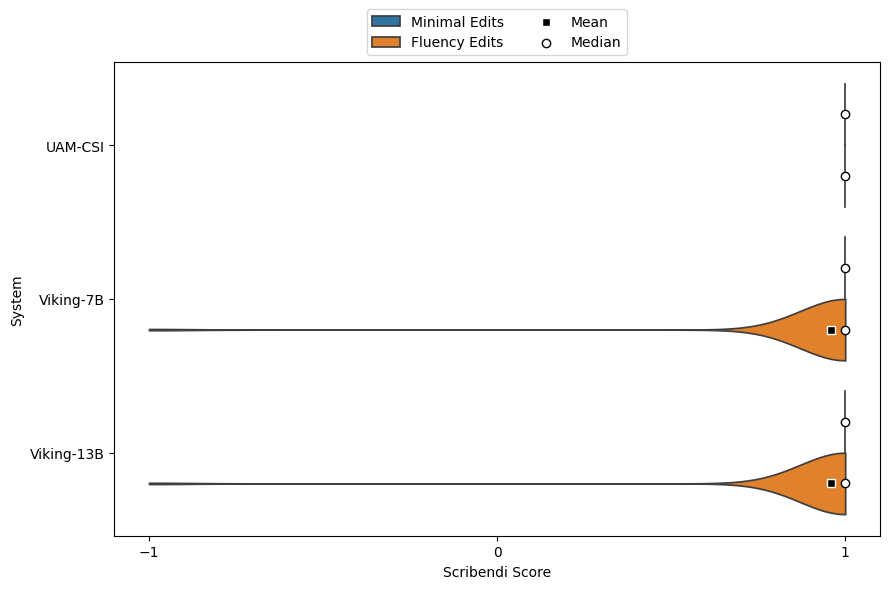

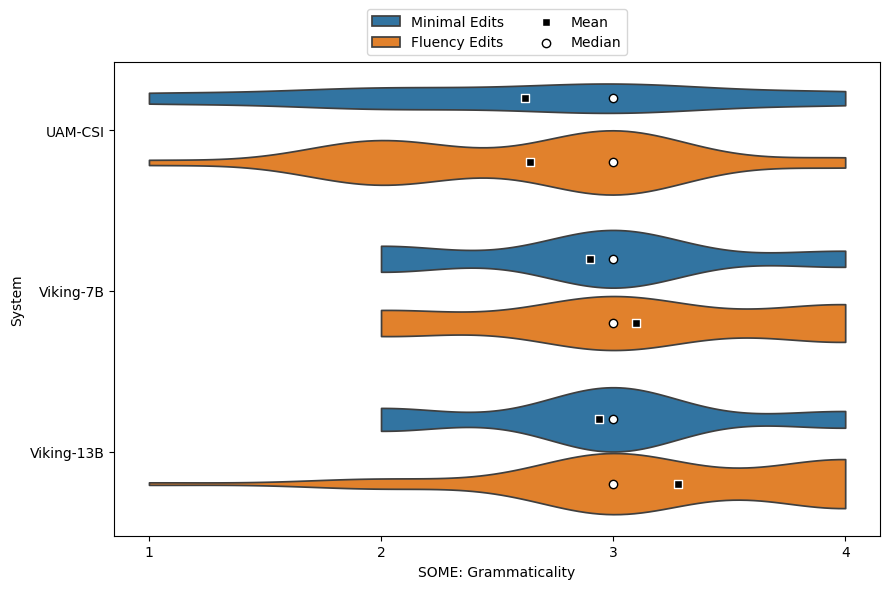

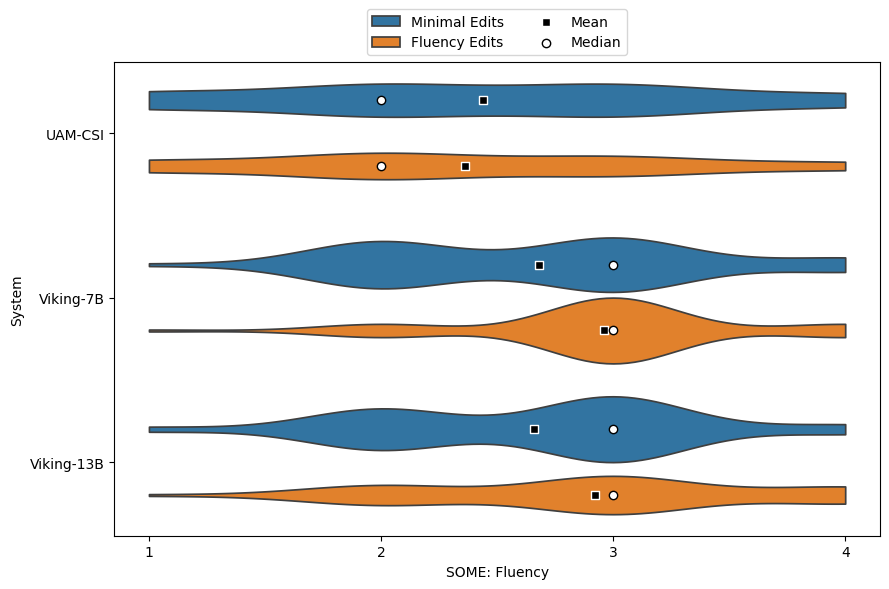

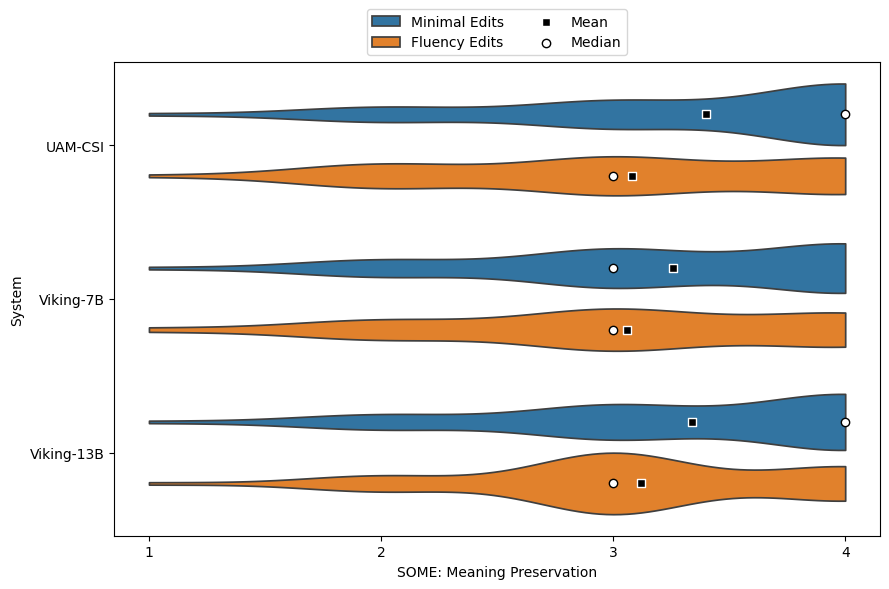

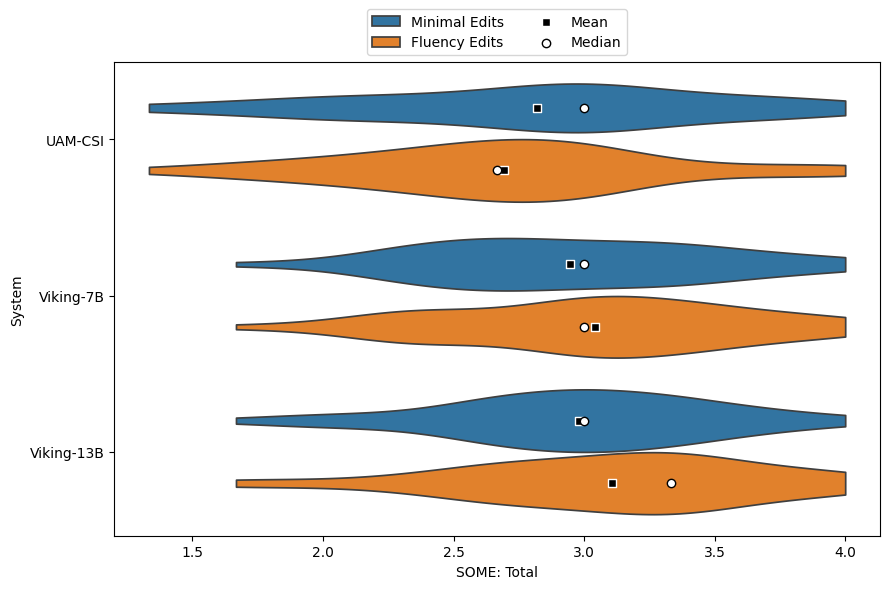

In [7]:
def format_legend_label(label):
    match label:
        case "minimal":
            return "Minimal Edits"
        case "fluency":
            return "Fluency Edits"
        case _:
            return output_metrics.get(label, label).replace("_", " ").title()


def normalize_file_name(file_name):
    return file_name.lower().replace(".", "").replace(" ", "_")


plots_dir = "plots/"
makedirs(plots_dir, exist_ok=True)

metric_types = {
    "continuous": [
        "gleu",
        "precision",
        "recall",
        "f0.5",
        "manual_evaluation",
    ],
    "discrete": [
        "scribendi_score",
        "grammaticality",
        "fluency",
        "meaning_preservation",
    ],
}


def get_minmax(v):
    return v.min(), v.max()


def is_even(n):
    return n % 2 == 0


offset = 0.2


for metric in metrics:

    metric_df = df_long[df_long["metric"] == metric]

    fig, ax = plt.subplots(figsize=(9, 6))
    sns.violinplot(
        metric_df,
        y="system",
        x="score",
        cut=0,
        hue="correction_style",
        inner=None,
        density_norm="area",
    )
    grouped = metric_df.groupby(
        ["system", "correction_style"], observed=False
    )["score"]
    means = grouped.mean()
    medians = grouped.median()

    ys = [
        i // 2 - offset if is_even(i) else i // 2 + offset
        for i in range(len(means))
    ]
    plt.scatter(
        y=ys,
        x=means,
        marker="s",
        color="black",
        edgecolors="white",
        zorder=3,
        label="Mean",
    )
    plt.scatter(
        y=ys,
        x=medians,
        marker="o",
        color="white",
        edgecolors="black",
        zorder=3,
        label="Median",
    )

    if metric in metric_types["discrete"]:
        # Ensure axes show integers
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    ax.set(xlabel=output_metrics[metric], ylabel="System")

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, map(format_legend_label, labels))
    sns.move_legend(
        ax,
        "lower center",
        ncol=2,
        bbox_to_anchor=(0.5, 1),
        frameon=True,
    )
    file_name = f"{normalize_file_name(metric)}.png"
    file_path = path.join(plots_dir, file_name)
    plt.tight_layout()
    plt.savefig(file_path)
    plt.tight_layout()
    plt.show()

In [8]:
print(df_long.info())

<class 'pandas.core.frame.DataFrame'>
Index: 2700 entries, 0 to 1199
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   essay_id          2700 non-null   int64   
 1   correction_style  2700 non-null   category
 2   system            2700 non-null   category
 3   metric            2700 non-null   object  
 4   score             2700 non-null   float64 
dtypes: category(2), float64(1), int64(1), object(1)
memory usage: 89.9+ KB
None


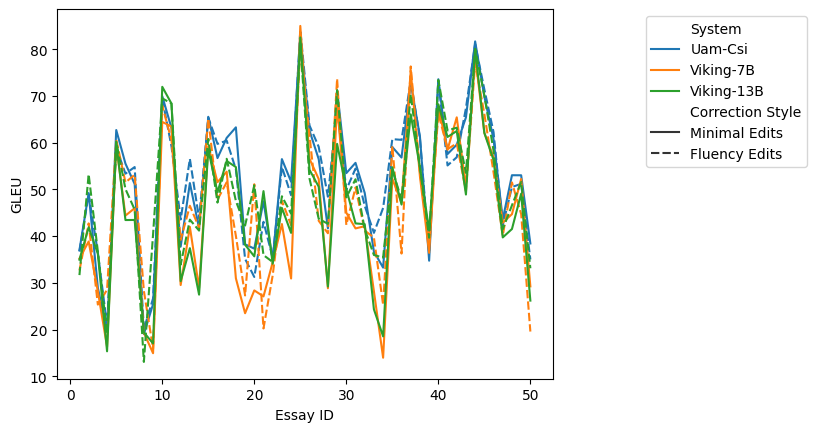

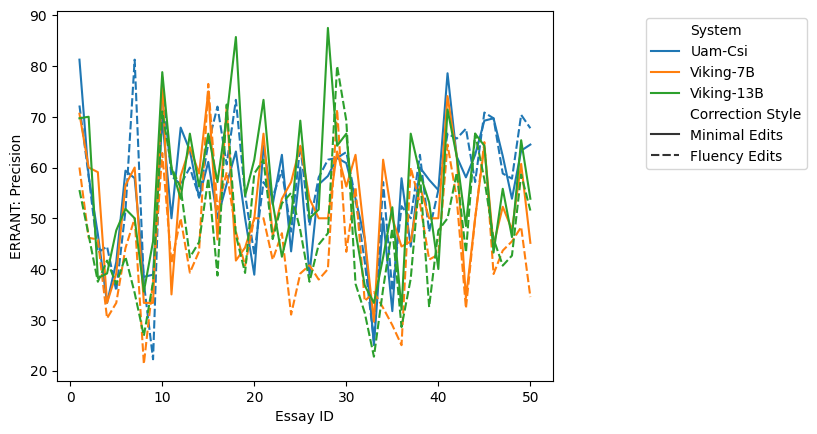

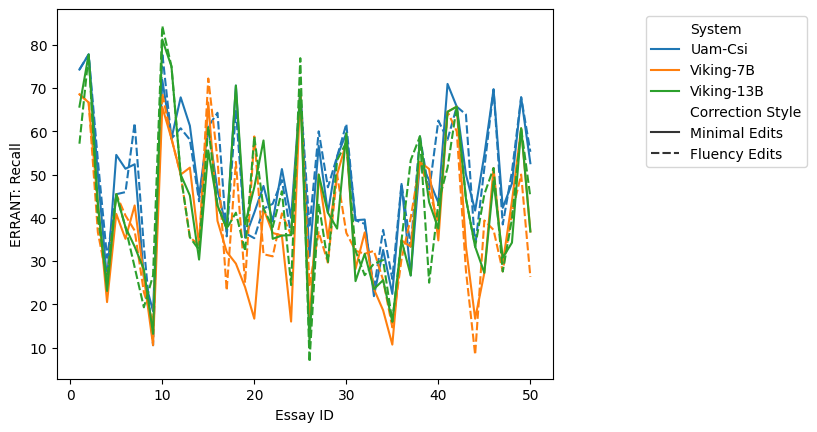

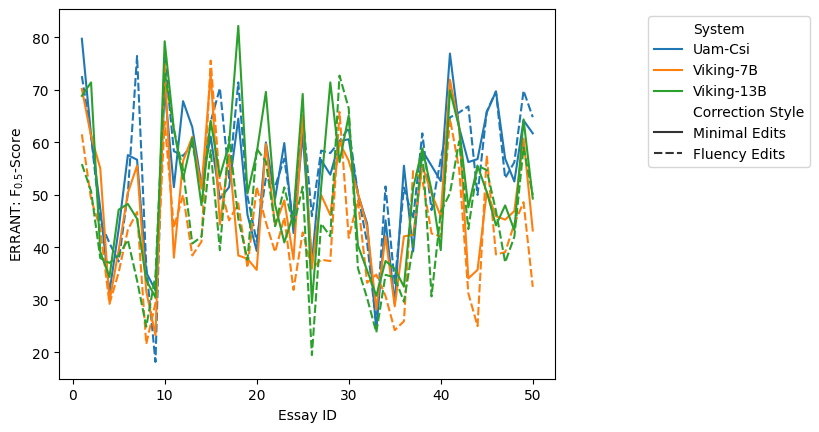

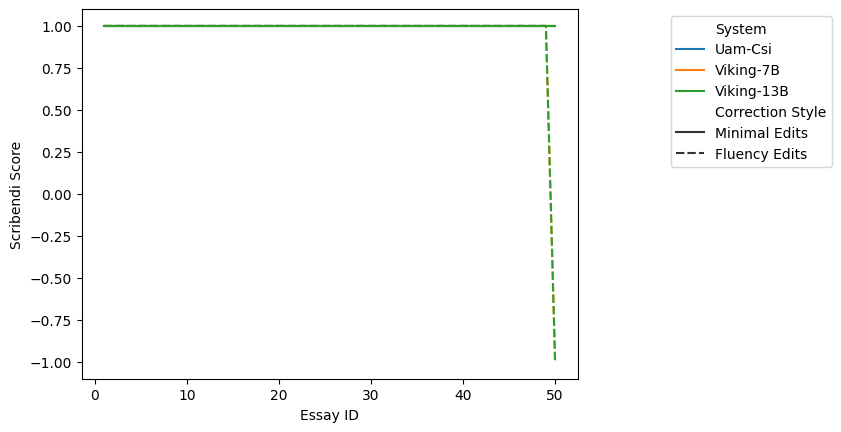

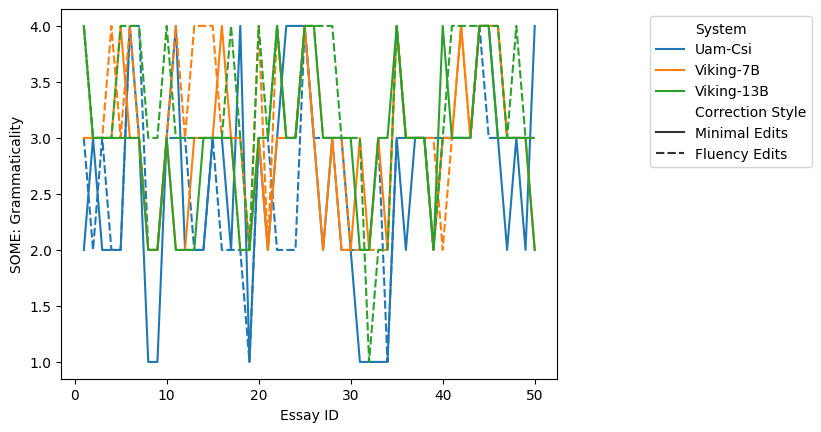

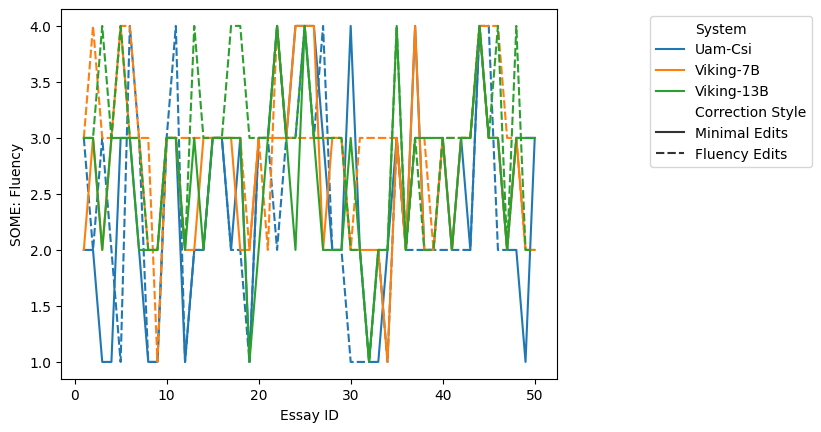

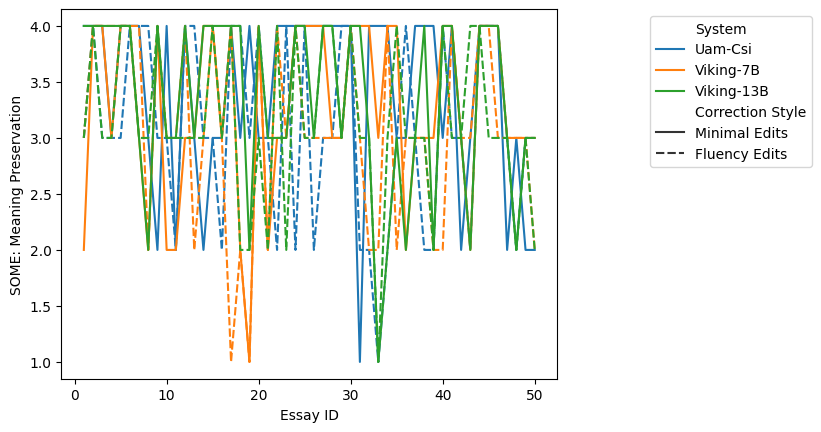

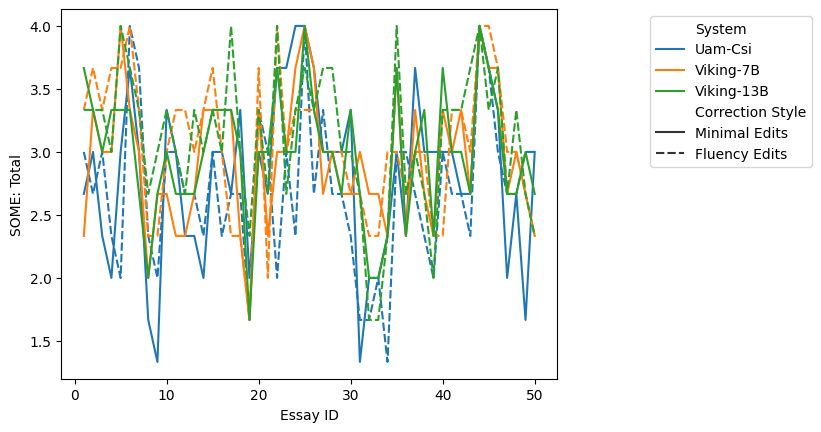

In [9]:
for metric in metrics:
    metric_df = df_long[df_long["metric"] == metric]
    ax = sns.lineplot(
        metric_df, x="essay_id", y="score", hue="system", style="correction_style"
    )
    ax.set(xlabel="Essay ID", ylabel=output_metrics[metric])
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, map(format_legend_label, labels))
    sns.move_legend(
        ax,
        "upper center",
        bbox_to_anchor=(1.35, 1),
        ncol=1,
        frameon=True,
    )
    plt.show()

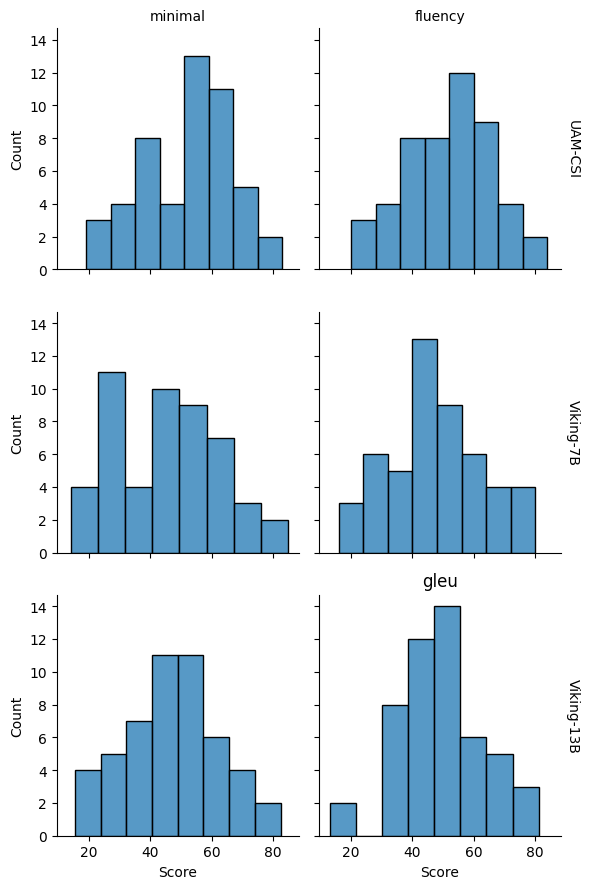

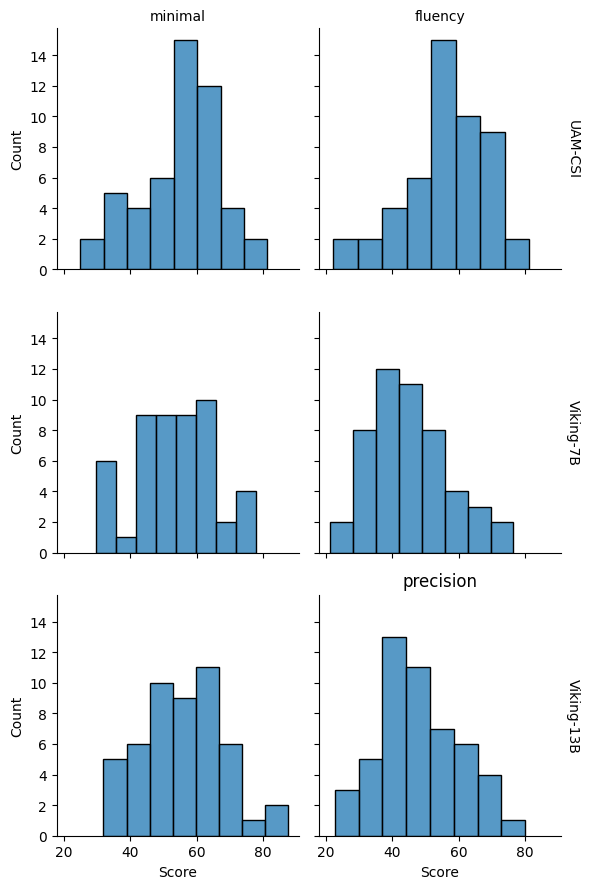

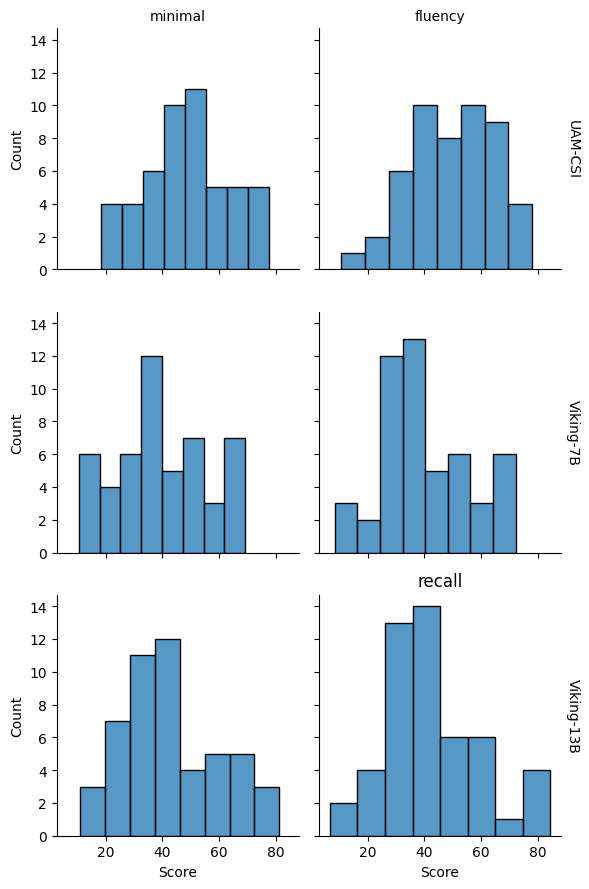

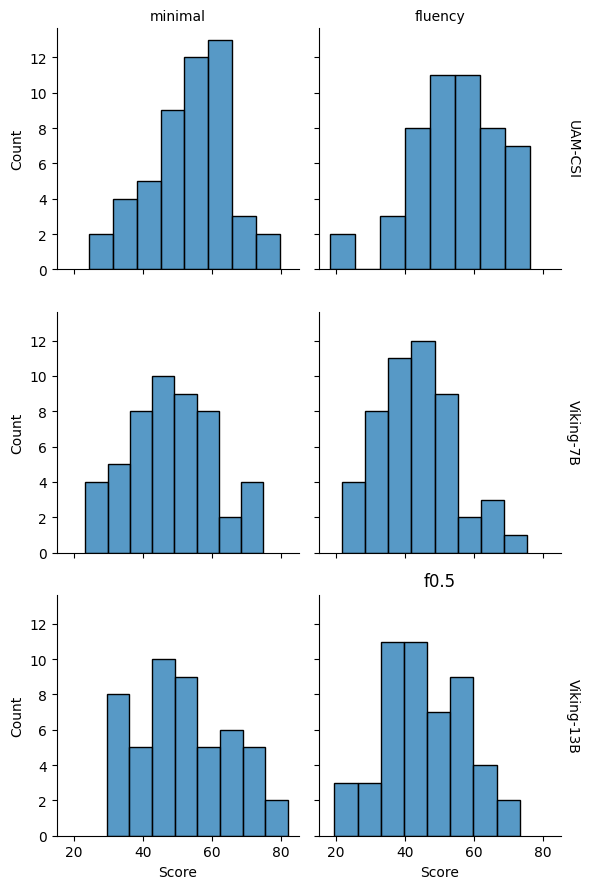

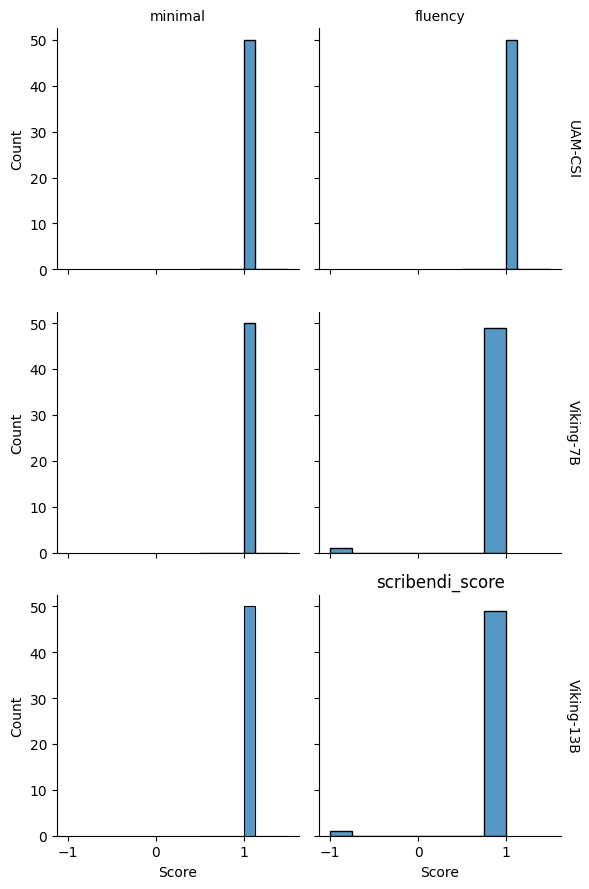

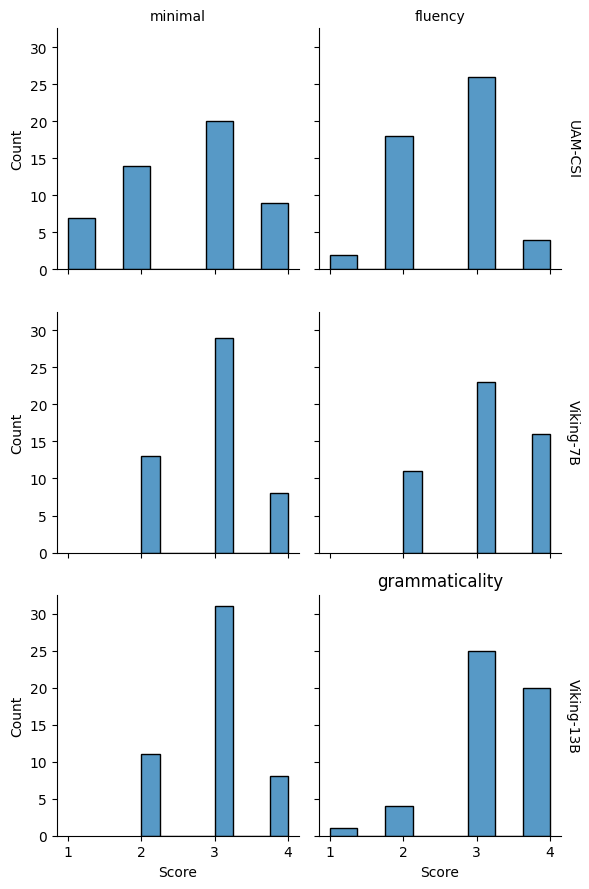

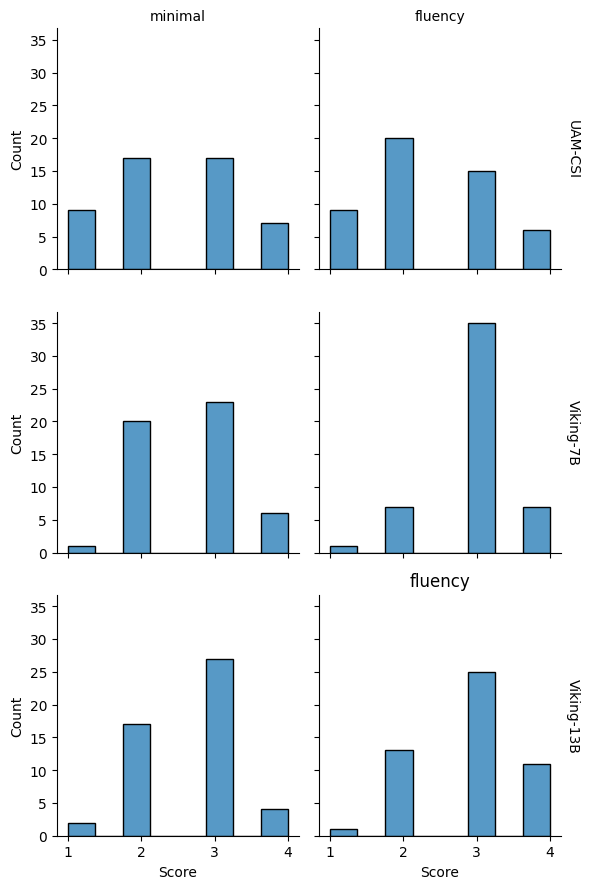

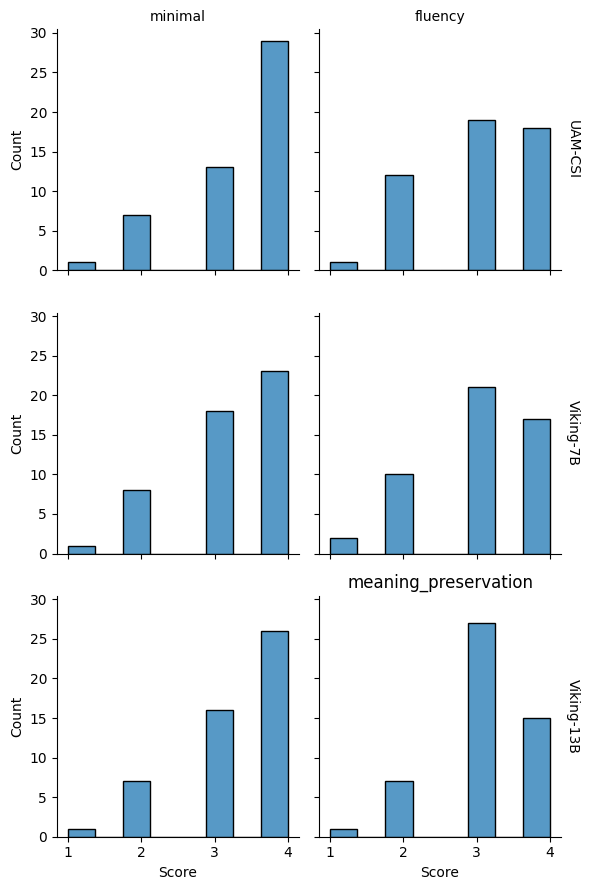

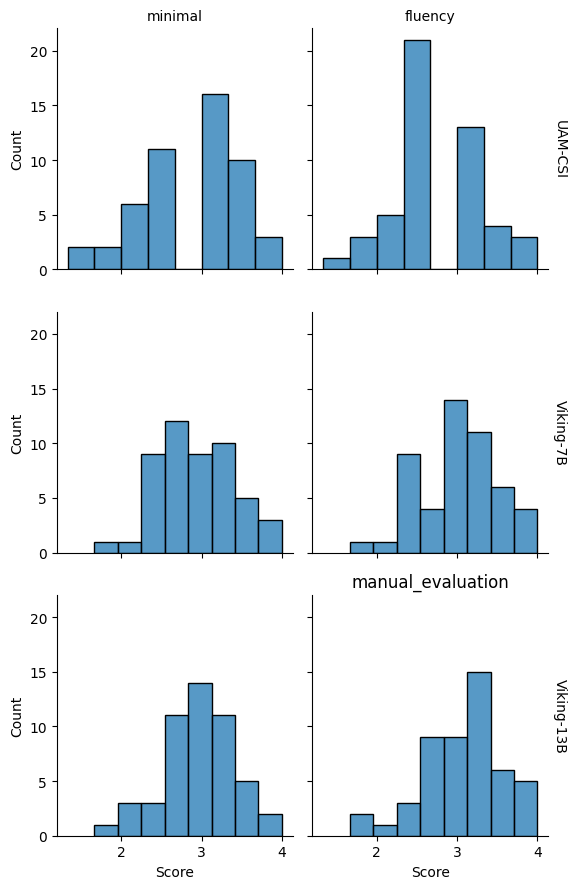

In [10]:
for metric in metrics:
    metric_df = df_long[df_long["metric"] == metric]
    g = sns.FacetGrid(
        metric_df,
        col="correction_style",
        row="system",
        margin_titles=True,
        sharex=True,
        sharey=True,
    )
    g.map_dataframe(sns.histplot, x="score", bins=8)

    # Set axis labels and titles
    g.set_axis_labels("Score", "Count")
    g.set_titles(row_template="{row_name}", col_template="{col_name}")

    plt.title(metric)

    plt.tight_layout()
    plt.show()

In [11]:
print(metrics)

['gleu', 'precision', 'recall', 'f0.5', 'scribendi_score', 'grammaticality', 'fluency', 'meaning_preservation', 'manual_evaluation']


In [12]:
def get_spread(x):
    return x.max() - x.min()


summary = (
    df_long.groupby(["correction_style", "system", "metric"])
    .agg(
        mean=("score", "mean"),
        median=("score", "median"),
        min=("score", "min"),
        max=("score", "max"),
        spread=("score", get_spread),
        # std=("score", "std"),
    )
    .reset_index()
)


metric_dfs = {
    metric: group.drop(columns="metric")
    .sort_values(by=["correction_style", "system"], ascending=[True, True])
    .reset_index(drop=True)
    for metric, group in summary.groupby("metric")
}


output_styles = {
    "minimal": "Minimal",
    "fluency": "Fluency",
}

output_headers = {
    "correction_style": "Edit Style",
    "system": "System",
}

mu = r"\( \mu \)"
sigma = r"\( \sigma \)"

for metric, metric_df in metric_dfs.items():
    metric_df.rename(columns=output_headers, inplace=True)
    metric_df["Edit Style"] = metric_df["Edit Style"].map(output_styles)
    metric_df.set_index(["Edit Style", "System"], inplace=True)

latex_args = {
    "sparse_index": True,
    "convert_css": True,
    "clines": "skip-last;data",
    "hrules": True,
    "column_format": None,
    "siunitx": True,
    "multicol_align": "c",
}

tables_dir = "tables/"
makedirs(tables_dir, exist_ok=True)
summary_dir = path.join(tables_dir, "summary")
makedirs(summary_dir, exist_ok=True)

highlight = {
    "max": "background-color: kth-lightblue40",
    "min": "background-color: kth-lightred40",
}


def float_formatter(x):
    return f"\\num{{{x:.2f}}}"


for metric, metric_df in metric_dfs.items():
    print(metric)

    latex = (
        # metric_df.style.highlight_max(
        #    subset=["mean", "median", "max", "min"], props=highlight["max"], axis=0
        # )
        # .highlight_min(subset=sigma, props="font-weight: bold", axis=0)
        metric_df.style.highlight_min(props=highlight["min"], axis=0)
        .highlight_max(props=highlight["max"], axis=0)
        .format(formatter=float_formatter)
        .to_latex(
            **latex_args,
        )
    )

    file_name = f"{normalize_file_name(metric)}.tex"
    file_path = path.join(summary_dir, file_name)
    with open(file_path, "w+") as f:
        f.write(latex)

    print(latex)

f0.5
\begin{tabular}{llSSSSS}
\toprule
{} & {} & {mean} & {median} & {min} & {max} & {spread} \\
{Edit Style} & {System} & {} & {} & {} & {} & {} \\
\midrule
\multirow[c]{3}{*}{Minimal} & UAM-CSI & \num{53.63} & \num{55.91} & \num{24.31} & \num{79.75} & \num{55.44} \\
 & Viking-7B & \num{48.33} & \num{46.53} & \num{23.26} & \num{75.00} & {\cellcolor{kth-lightred40}} \num{51.74} \\
 & Viking-13B & \num{51.74} & \num{50.42} & {\cellcolor{kth-lightblue40}} \num{29.41} & {\cellcolor{kth-lightblue40}} \num{82.19} & \num{52.78} \\
\cline{1-7}
\multirow[c]{3}{*}{Fluency} & UAM-CSI & {\cellcolor{kth-lightblue40}} \num{54.78} & {\cellcolor{kth-lightblue40}} \num{56.52} & {\cellcolor{kth-lightred40}} \num{18.18} & \num{76.47} & {\cellcolor{kth-lightblue40}} \num{58.29} \\
 & Viking-7B & {\cellcolor{kth-lightred40}} \num{43.11} & {\cellcolor{kth-lightred40}} \num{42.75} & \num{21.59} & \num{75.58} & \num{53.99} \\
 & Viking-13B & \num{45.73} & \num{44.02} & \num{19.48} & {\cellcolor{kth-lightred4

/tmp/ipykernel_31298/3090337329.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_long.groupby(["correction_style", "system", "metric"])


In [13]:
discrete_metrics = metric_types["discrete"]

discrete_df = df_long[df_long["metric"].isin(discrete_metrics)]


def int_formatter(x):
    return f"\\num{{{x}}}"


for metric in discrete_metrics:
    metric_df = (
        discrete_df[discrete_df["metric"] == metric]
        .drop(columns=["metric", "essay_id"])
        .reset_index(drop=True)
    )
    metric_df.rename(columns=output_headers, inplace=True)
    metric_df["Edit Style"] = metric_df["Edit Style"].map(output_styles)
    metric_df["score"] = metric_df["score"].astype(int)
    mean = metric_df.groupby(["Edit Style", "System"], observed=False)["score"].mean()
    median = metric_df.groupby(["Edit Style", "System"], observed=False)[
        "score"
    ].median()
    metric_df = metric_df.pivot_table(
        index=["Edit Style", "System"],
        columns="score",
        aggfunc="size",
        fill_value=0,
        observed=False,
    )
    metric_df["mean"] = mean
    metric_df["median"] = median
    cols = ["mean", "median"] + list(metric_df.columns[:-2])
    metric_df = metric_df[cols]
    metric_df.columns = pd.MultiIndex.from_tuples(
        [
            ("", col) if col in ["mean", "median"] else ("Score Count", col)
            for col in metric_df.columns
        ]
    )
    print(metric)
    print(metric_df)

    latex = (
        metric_df.style.highlight_min(props=highlight["min"], axis=0)
        .highlight_max(props=highlight["max"], axis=0)
        .format(formatter=float_formatter, subset=[("", "mean"), ("", "median")])
        .format(formatter=int_formatter, subset=["Score Count"])
        .to_latex(
            **latex_args,
        )
    )

    file_name = f"{normalize_file_name(metric)}.tex"
    file_path = path.join(summary_dir, file_name)
    with open(file_path, "w+") as f:
        f.write(latex)

    print(latex)

scribendi_score
                                   Score Count    
                       mean median          -1   1
Edit Style System                                 
Minimal    UAM-CSI     1.00    1.0           0  50
           Viking-7B   1.00    1.0           0  50
           Viking-13B  1.00    1.0           0  50
Fluency    UAM-CSI     1.00    1.0           0  50
           Viking-7B   0.96    1.0           1  49
           Viking-13B  0.96    1.0           1  49
\begin{tabular}{llSSSS}
\toprule
{} & {} & \multicolumn{2}{c}{} & \multicolumn{2}{c}{Score Count} \\
{} & {} & {mean} & {median} & {-1} & {1} \\
{Edit Style} & {System} & {} & {} & {} & {} \\
\midrule
\multirow[c]{3}{*}{Minimal} & UAM-CSI & {\cellcolor{kth-lightblue40}} \num{1.00} & {\cellcolor{kth-lightred40}} {\cellcolor{kth-lightblue40}} \num{1.00} & {\cellcolor{kth-lightred40}} \num{0} & {\cellcolor{kth-lightblue40}} \num{50} \\
 & Viking-7B & {\cellcolor{kth-lightblue40}} \num{1.00} & {\cellcolor{kth-lightred40}} {

In [14]:
metric_types["continuous"].remove("manual_evaluation")
metric_types["discrete"].append("manual_evaluation")

In [15]:
significance_level = 0.05

dists = []
grouped = df_long.groupby(
    ["system", "correction_style", "metric"], observed=False
)

for metric in metric_types["continuous"]:
    for team in teams:
        for style in styles:
            scores = grouped.get_group((team, style, metric))[
                "score"].to_numpy()

            shapiro_stat, shapiro_p = shapiro(scores)
            normaltest_stat, normaltest_p = normaltest(scores)

            dists.append(
                {
                    "metric": metric,
                    "team": team,
                    "style": style,
                    # "shapiro_stat": shapiro_stat,
                    "sp": shapiro_p,
                    "sn": shapiro_p > significance_level,
                    # "normaltest_stat": normaltest_stat,
                    "np": normaltest_p,
                    "nn": normaltest_p > significance_level,
                }
            )

dist_df = pd.DataFrame(dists)
print(dist_df)

       metric        team    style        sp    sn        np    nn
0        gleu     UAM-CSI  minimal  0.537457  True  0.717056  True
1        gleu     UAM-CSI  fluency  0.901659  True  0.890217  True
2        gleu   Viking-7B  minimal  0.617159  True  0.622972  True
3        gleu   Viking-7B  fluency  0.732172  True  0.808066  True
4        gleu  Viking-13B  minimal  0.904409  True  0.961554  True
5        gleu  Viking-13B  fluency  0.512281  True  0.814185  True
6   precision     UAM-CSI  minimal  0.170091  True  0.329197  True
7   precision     UAM-CSI  fluency  0.191668  True  0.087576  True
8   precision   Viking-7B  minimal  0.561792  True  0.798274  True
9   precision   Viking-7B  fluency  0.508271  True  0.246715  True
10  precision  Viking-13B  minimal  0.565416  True  0.694746  True
11  precision  Viking-13B  fluency  0.472608  True  0.407077  True
12     recall     UAM-CSI  minimal  0.476903  True  0.549171  True
13     recall     UAM-CSI  fluency  0.535215  True  0.749166  

In [ ]:
baseline = "UAM-CSI"
vikings = [t for t in teams if t != baseline]

alternative_hypothesis = {
    1: "greater",
    2: "less",
}


def perform_statistical_tests(hypothesis):
    test_results = []

    for team in vikings:
        for metric in metrics:
            for style in styles:
                keys = [team, baseline]
                args = [(k, style, metric) for k in keys]
                scores = [
                    grouped.get_group(arg).sort_values(
                        by="essay_id"
                    )["score"].to_numpy()
                    for arg in args
                ]

                if metric in metric_types["continuous"]:
                    stat, p_value = ttest_rel(
                        scores[0], scores[1], alternative=alternative_hypothesis[hypothesis]
                    )
                else:
                    diffs = np.around(scores[0] - scores[1], 3)
                    stat, p_value = wilcoxon(
                        diffs, alternative=alternative_hypothesis[hypothesis]
                    )

                test_results.append(
                    {
                        "team": team,
                        "style": style,
                        "metric": metric,
                        "statistic": stat,
                        "p_value": p_value,
                        "hypothesis": hypothesis,
                        "significant": p_value < significance_level,
                    }
                )

    return test_results

## Test Multi Index

In [19]:
pos = perform_statistical_tests(1)
neg = perform_statistical_tests(2)
test_results = pos + neg
test_results_df = pd.DataFrame(test_results)

/home/karl/kth/courses/da231x/da231x/evaluate/plot-env/lib/python3.13/site-packages/scipy/stats/_wilcoxon.py:172: RuntimeWarning: invalid value encountered in scalar divide
  z = (r_plus - mn) / se


In [49]:
pretty_test_results_df = test_results_df.copy()
cols = ["metric", "style", "team", "p_value", "hypothesis"]
pretty_test_results_df = pretty_test_results_df[cols].reset_index(drop=True)

output_headers = {
    "style": "Edit Style",
    "team": "System",
    "p_value": "$ p $-value",
    "significant": "Significant",
    "metric": "Metric",
    "statistic": "Statistic",
    "hypothesis": "Hypothesis",
}

output_hypothesis = {
    n: f"$ H_{{{n}}} $"
    for n in [1, 2]
}

metric_order = CategoricalDtype(
    categories=[
        "GLEU",
        "ERRANT",
        "Scribendi Score",
        "SOME",
    ],
    ordered=True,
)

submetrics_raw = [
    "precision",
    "recall",
    "f0.5",
    "grammaticality",
    "fluency",
    "meaning_preservation",
    "manual_evaluation",
]

submetrics = [
    output_metrics[submetric].split(":")[1].strip() for submetric in submetrics_raw
] + ["-"]

submetric_order = CategoricalDtype(
    categories=submetrics,
    ordered=True,
)

style_order = CategoricalDtype(
    categories=["Minimal", "Fluency"],
    ordered=True,
)

system_order = CategoricalDtype(
    categories=["Viking-7B", "Viking-13B"],
    ordered=True,
)

renamed = pretty_test_results_df.rename(columns=output_headers)
renamed["Edit Style"] = renamed["Edit Style"].map(output_styles)

renamed["Metric"] = renamed["Metric"].map(output_metrics)

renamed[
    ["Metric", "Submetric"]
] = renamed["Metric"].str.split(":", expand=True)
renamed["Submetric"] = renamed["Submetric"].str.strip().fillna("-")

renamed["Hypothesis"] = renamed["Hypothesis"].map(output_hypothesis)

renamed["Edit Style"] = renamed["Edit Style"].astype(style_order)
renamed["Metric"] = renamed["Metric"].astype(metric_order)
renamed["Submetric"] = renamed["Submetric"].astype(submetric_order)
renamed["System"] = renamed["System"].astype(system_order)

renamed = renamed.pivot(
    index=["Metric", "Submetric", "Edit Style", "System"],
    columns=["Hypothesis"],
    values=[output_headers["p_value"]]
)


latex_args["column_format"] = None
latex_args["siunitx"] = True


def scientific_formatter(x):
    if pd.notnull(x):
        pretty = f"{x:.2e}"
        return f"\\num{{{pretty}}}"
    return f"\\text{{NaN}}"


green = "background-color: kth-lightgreen"
red = "background-color: kth-lightred"
latex = (
    renamed.style.map(
        lambda p: (green if float(p) < significance_level else ""), subset=[(output_headers["p_value"], output_hypothesis[1])]
    )
    .map(
        lambda p: (red if float(p) < significance_level else ""), subset=[(output_headers["p_value"], output_hypothesis[2])]
    )
    .format(formatter=scientific_formatter)
    .to_latex(**latex_args)
)


print(latex)
file_name = "test_results.tex"
file_path = path.join(tables_dir, file_name)
with open(file_path, "w+") as f:
    f.write(latex)

\begin{tabular}{llllSS}
\toprule
{} & {} & {} & {} & \multicolumn{2}{c}{$ p $-value} \\
{} & {} & {} & {Hypothesis} & {$ H_{1} $} & {$ H_{2} $} \\
{Metric} & {Submetric} & {Edit Style} & {System} & {} & {} \\
\midrule
\multirow[c]{4}{*}{GLEU} & \multirow[c]{4}{*}{-} & \multirow[c]{2}{*}{Minimal} & Viking-7B & \num{1.00e+00} & {\cellcolor{kth-lightred}} \num{9.77e-10} \\
 &  &  & Viking-13B & \num{1.00e+00} & {\cellcolor{kth-lightred}} \num{4.09e-09} \\
\cline{3-6}
 &  & \multirow[c]{2}{*}{Fluency} & Viking-7B & \num{1.00e+00} & {\cellcolor{kth-lightred}} \num{3.87e-05} \\
 &  &  & Viking-13B & \num{9.96e-01} & {\cellcolor{kth-lightred}} \num{3.86e-03} \\
\cline{1-6} \cline{2-6} \cline{3-6}
\multirow[c]{12}{*}{ERRANT} & \multirow[c]{4}{*}{Precision} & \multirow[c]{2}{*}{Minimal} & Viking-7B & \num{9.26e-01} & \num{7.40e-02} \\
 &  &  & Viking-13B & \num{3.18e-01} & \num{6.82e-01} \\
\cline{3-6}
 &  & \multirow[c]{2}{*}{Fluency} & Viking-7B & \num{1.00e+00} & {\cellcolor{kth-lightred}} \